Read output txt file from elastix and locate where they are in the brain

In [20]:
import os

import pandas as pd

import numpy as np

import SimpleITK as sitk

import warnings

import tkinter.filedialog as fdialog

import matplotlib.pyplot as plt

import skimage
from skimage import io

import random

import seaborn as sns


In [38]:
points_name=fdialog.askopenfile( title='Select the downsampled points(transformed if sample2ara, non-transformed if ara2sample)').name

atlas_name=fdialog.askopenfile( title='Select the corresponding atlas').name

outdir = fdialog.askdirectory(title='Please select the output directory')

atlas= sitk.ReadImage(atlas_name)

atlas.GetSize()

(456, 320, 313)

In [39]:
# csv_name=fdialog.askopenfile(initialdir='D:\', title='Select the csv file with labels').name

# atlas_labels= pd.read_csv(csv_name)

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [40]:
#Read the output points
output=open(points_name,'r')
outputpoint= output.readlines()

### The next 3 cells are only for points that are transformed(after sample2ara)

In [41]:
#This section is only for points that are transformed(after sample2ara)
key_word='OutputIndexFixed'
length=len(key_word)

all_points=[]
for lines in outputpoint:
    start= lines.find('OutputIndexFixed')
    this_line=lines[start+length+5:start+length+17] 
    this_line= this_line.split(' ')
    mypoints=[int(stuff) for stuff in this_line if stuff.isnumeric()]
    all_points.append(mypoints)

#this is a very stupid way of finding the output points
# note that we convert string into integer here

In [44]:
points_in_atlas=[int(atlas[i]) for i in all_points ]

unique_id_inbrain=set(points_in_atlas)

our_regions=atlas_labels.loc[atlas_labels['id'].isin (unique_id)]

id_withcounts=[]
for i in unique_id:
    id_withcounts.append([i, points_in_atlas.count(i)])

new_df= pd.DataFrame(id_withcounts, columns=['id', 'counts'])
our_regionWcounts=pd.merge(atlas_labels, new_df)
our_regionWcounts.head()

,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,...,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,counts
0,1047,979.0,"Primary somatosensory area, barrel field, layer 4",SSp-bfd4,11,1,3,8690,329.0,9,...,/997/8/567/688/695/315/453/322/329/1047/,188064,NaN,NaN,f,55,3439709501,734881840,Primary somatosensory area barrel field layer 4,2298
1,600,923.0,"Dorsal auditory area, layer 2/3",AUDd2/3,11,1,3,8690,1011.0,8,...,/997/8/567/688/695/315/247/1011/600/,019399,NaN,NaN,f,125,2148227545,734881840,Dorsal auditory area layer 2/3,2193
2,678,650.0,"Dorsal auditory area, layer 4",AUDd4,11,1,3,8690,1011.0,8,...,/997/8/567/688/695/315/247/1011/678/,019399,NaN,NaN,f,126,3650389730,734881840,Dorsal auditory area layer 4,873
3,873,1099.0,"Supplemental somatosensory area, layer 1",SSs1,11,1,3,8690,378.0,8,...,/997/8/567/688/695/315/453/378/873/,188064,NaN,NaN,f,102,697782769,734881840,Supplemental somatosensory area layer 1,2151
4,1038,978.0,"Primary somatosensory area, barrel field, laye...",SSp-bfd6a,11,1,3,8690,329.0,9,...,/997/8/567/688/695/315/453/322/329/1038/,188064,NaN,NaN,f,57,2183435549,734881840,Primary somatosensory area barrel field layer 6a,1400


In [49]:
# In case of suboptimal registration, some points will fall out of the atlas (and will give a 0 index)
# check for this and thrown a warning

id_inatlas=[]
for x in atlas_labels['id']:
    intID = int(x)
    id_inatlas.append(intID)

# need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

for id_inbrain in unique_id_inbrain:
    if id_inbrain not in id_inatlas:
        if id_inbrain==0:
            
            print(id_inbrain,'this index is outside of the brain, consider possible suboptimal image registration')
        else: 
            print(id_inbrain,'this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37')
        warnings.warn('Some points do not have corresponding labels')

182305696 this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37
182305712 this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Some points do not have corresponding labels


### The next cells are only for points that are not transformed (after ara2sample)

In [5]:
# This section is only for points that are not transformed (after ara2sample)
all_points=[]
for lines in outputpoint[2:]:
    this_line= lines.split (' ')
    mypoints= [int(stuff) for stuff in this_line]
    all_points.append(mypoints)

In [11]:
points_in_atlas=[int(atlas[i]) for i in all_points ]

unique_id=set(points_in_atlas)

our_regions=atlas_labels.loc[atlas_labels['id'].isin (unique_id)]

id_withcounts=[]
for i in unique_id:
    id_withcounts.append([i, points_in_atlas.count(i)])

new_df= pd.DataFrame(id_withcounts, columns=['id', 'counts'])
our_regionWcounts=pd.merge(atlas_labels, new_df)
our_regionWcounts.head()

our_regionWcounts.to_excel(outdir+'/RegionCounts.xlsx')

In [7]:
our_regionWcounts['safe_name']

0       Primary somatosensory area barrel field layer 4
1                        Dorsal auditory area layer 2/3
2                          Dorsal auditory area layer 4
3                     Anterolateral visual area layer 5
4                      Anteromedial visual area layer 4
5        Primary somatosensory area upper limb layer 6a
6                            Primary motor area Layer 5
7      Primary somatosensory area barrel field layer 6a
8       Primary somatosensory area upper limb layer 2/3
9         Primary somatosensory area upper limb layer 4
10                          Rostrolateral area layer 6b
11                    Anterolateral visual area layer 4
12            Primary somatosensory area trunk layer 6a
13                         Dorsal auditory area layer 5
14                  Anterolateral visual area layer 2/3
15     Primary somatosensory area barrel field layer 6b
16        Primary somatosensory area upper limb layer 5
17                                      corpus c

In [8]:
# In case of suboptimal registration, some points will fall out of the atlas (and will give a 0 index)
# check for this and thrown a warning

id_inatlas=[]
for x in atlas_labels['id']:
    intID = int(x)
    id_inatlas.append(intID)

# need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

for id_inbrain in unique_id_inbrain:
    if id_inbrain not in id_inatlas:
        if id_inbrain==0:
            
            print(id_inbrain,'this index is outside of the brain, consider possible suboptimal image registration')
        else: 
            print(id_inbrain,'this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37')
        warnings.warn('Some points do not have corresponding labels')

        
# Turns out these big numbers exist in atlas but have no name in the json file..ask on allen brain map community forum
# the 0 index is points out of the brain b/c registration problem

0 this index does not exist in allen reference atlas, consider possible suboptimal image registration
312782592 this index does not exist in allen reference atlas, consider possible suboptimal image registration
182305696 this index does not exist in allen reference atlas, consider possible suboptimal image registration
182305712 this index does not exist in allen reference atlas, consider possible suboptimal image registration
312782560 this index does not exist in allen reference atlas, consider possible suboptimal image registration


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Consider possible suboptimal image registration
  


## Now the two methods converge, continue here

count the numberof points in each region andplot as a percentage

Save the points position as a tiff stack to later project to the brain

In [50]:
#Plot the result

our_regionWcounts=our_regionWcounts.sort_values(by=['counts'])

percent=100*our_regionWcounts['counts']/np.sum(our_regionWcounts['counts'])

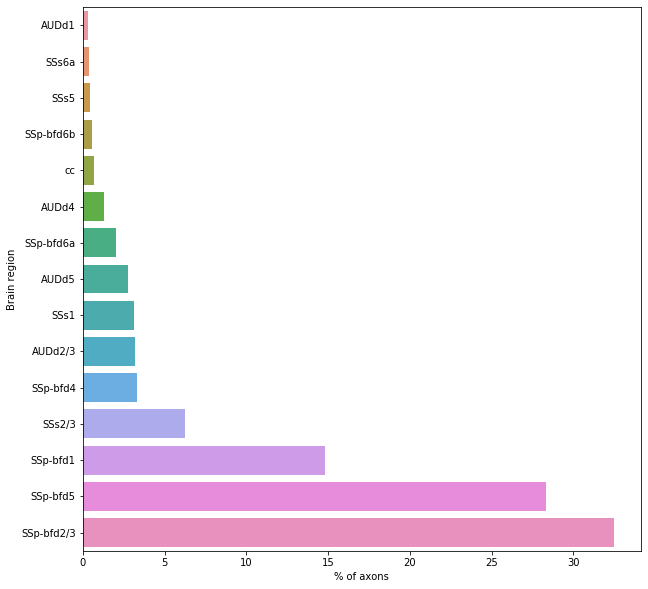

In [13]:
fig, ax = plt.subplots(figsize=[10,10])
my_plot=sns.barplot(y="acronym", x=percent, data=our_regionWcounts)
ax.set(xlabel='% of axons', ylabel='Brain region')
sns.set_context("talk")
sns.set_palette("pastel")
fig.savefig(outdir+"/RegionPlot.svg")

In [14]:
# Now project downsampled points into tiff to see if they make sense
svolume=np.zeros(atlas.GetSize())
#columns, rows, planes

zplanes=[]
for i in all_points:
    zplanes.append( i[2])
zplanes=np.unique(zplanes)
zplanes

array([142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194])

In [15]:
temp=np.zeros(atlas.GetSize()[0:2])
thepoints=np.asarray(all_points)

for i in zplanes:
    index= thepoints[:,2]==i
    uindex,counts=np.unique(thepoints[index],return_counts=True, axis=0)
    for j, lines in enumerate(uindex):
        coord1,coord2=lines[0:2]
        temp[coord1][coord2]= counts[j]
    svolume[:,:,i]=temp #write this in 
    temp=np.zeros(atlas.GetSize()[0:2]) #reset the empty plane after each z

In [16]:
for j, lines in enumerate(uindex):
    coord1,coord2=lines[0:2]
    temp[coord1][coord2]= counts[j]

displaying plane 169


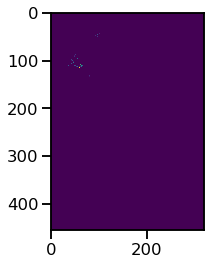

In [17]:
ztoshow=random.choice(zplanes)
plt.imshow(svolume[:,:,ztoshow])
print(f'displaying plane {ztoshow}' )

In [18]:
coronal_planetmp= np.swapaxes(np.int16(svolume),0,2)
#for some reason, if just save stuff as tiff, it will save x planes of yz view
#here we shift the 3rd dimension with the first dimension to obtain xy view

io.imsave(outdir+'/DS_points.tif',coronal_planetmp)

C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/AL110/sample2ara_points/DS_points.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


## Plots the non'downsampled points in 3d space

In [51]:
import plotly
import plotly.graph_objects as go
from plotly import __version__
print(__version__)


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

4.5.0


In [52]:
ori_points_name=fdialog.askopenfile( title='Select the converted&resampled origional points').name

#Load the origional points
anno=open(ori_points_name,'r')
anno_data=anno.readlines()
# heading is stored in anno_data[2], 1st line basically useless

headings=anno_data[2].rstrip('\n').replace(' ', '').split(',')
annotations=[lines.rstrip(' 0\n').split(' ') for lines in anno_data[3:]]
#slight modification on replacing and stripping due to the format of the resampled swc
annotation_df=pd.DataFrame(annotations, columns=headings)

annotation_df.head()

,#id,type,x,y,z,r,pid
0,1,3,4553.51,1962.31,3650,1,2
1,2,3,4552.53,1962.41,3649.85,1,3
2,3,3,4551.54,1962.51,3649.69,1,4
3,4,3,4550.56,1962.61,3649.54,1,5
4,5,3,4549.91,1962.77,3649.08,1,6


In [53]:
points_with_id= pd.DataFrame (zip(annotation_df['x'],annotation_df['y'], annotation_df['z'],points_in_atlas ), columns=['x', 'y','z', 'atlasID'])
points_with_id.to_csv (outdir+'/resamp_oripoints_withID.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path
points_with_id.head(10)

,x,y,z,atlasID
0,4553.51,1962.31,3650,981
1,4552.53,1962.41,3649.85,981
2,4551.54,1962.51,3649.69,981
3,4550.56,1962.61,3649.54,981
4,4549.91,1962.77,3649.08,981
5,4549.79,1963.05,3648.13,981
6,4549.67,1963.32,3647.17,981
7,4549.6,1963.82,3646.35,981
8,4549.6,1964.56,3645.69,981
9,4549.58,1965,3646.3,981


In [55]:
len(points_with_id)
# this is the total length (in um) of the trace if the trace is resampled in 1um steps

70651

In [73]:
#Assign a colour to each unique atlas ID for plotting
#this is need because atlas IDs has very high values which is outside of the colour range
uniqueID=np.unique(points_with_id['atlasID'])
colour= np.linspace(1,np.size(uniqueID)+1, num=np.size(uniqueID),dtype='int')

colourdict=dict(zip(uniqueID,colour))

In [74]:
#colourdict=dict(zip(atlas_labels['id'], atlas_labels['color_hex_triplet']))
# cannot use the allen atlases colour because some are not recognized by plotly

In [75]:
namedict=dict(zip(atlas_labels['id'],atlas_labels['name']))
points_with_id['name'] = points_with_id['atlasID'].map(namedict)

points_with_id['colour'] = points_with_id['atlasID'].map(colourdict)
points_with_id.head()

,x,y,z,atlasID,name,colour
0,4553.51,1962.31,3650,981,"Primary somatosensory area, barrel field, layer 1",10
1,4552.53,1962.41,3649.85,981,"Primary somatosensory area, barrel field, layer 1",10
2,4551.54,1962.51,3649.69,981,"Primary somatosensory area, barrel field, layer 1",10
3,4550.56,1962.61,3649.54,981,"Primary somatosensory area, barrel field, layer 1",10
4,4549.91,1962.77,3649.08,981,"Primary somatosensory area, barrel field, layer 1",10


In [68]:
trace= go.Scatter3d( 
    x=points_with_id[::3]['x'],
    y=points_with_id[::3]['y'],
    z=points_with_id[::3]['z'],
    mode='markers',
    marker=dict(
        size=1,
        color=points_with_id[::3]['colour'],
        opacity=0.5),
    hovertext= points_with_id[::3]['name'],
    hoverinfo='text'
)

layout=go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0)
)

#Here we want horizontal view with dorsal surface toward us
#first we set a xz view for coronal section this is done by setting x and z as 0 in eye
# then, for y we want the smaller values to point toward us (because in our original coronal images dorsal surface is pointed up)
camera = dict(
    eye=dict(x=0, y=-1, z=0)
)


#Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
fig=go.Figure(data=trace,layout=layout)
fig.update_layout(scene_camera=camera, 
                  scene=dict(
                    xaxis_title='Smaller=more medial',
                    yaxis_title='Smaller=more dorsal',
                    zaxis_title='Smaller=more anterior'))
plot(fig,filename=outdir+'/'+ outdir[3:8]+'resampled3Dplot.html')

ValueError: 
    Invalid element(s) received for the 'color' property of scatter3d.marker
        Invalid elements include: ['188064', '188064', '188064', '188064', '188064', '188064', '188064', '188064', '188064', '188064']

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen
      - A number that will be interpreted as a color
        according to scatter3d.marker.colorscale
      - A list or array of any of the above